In [47]:
%matplotlib inline
from path import Path

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [48]:
aps = pd.read_csv('ApplianceShipments.csv')

In [49]:
aps

,Quarter,Shipments
0,Q1-1985,4009
1,Q2-1985,4321
2,Q3-1985,4224
3,Q4-1985,3944
4,Q1-1986,4123
5,Q2-1986,4522
6,Q3-1986,4657
7,Q4-1986,4030
8,Q1-1987,4493
9,Q2-1987,4806


The method that would be suitable for forecasting this series if applied to the raw data is Holt-Winter's exponential smoothing

In [50]:
date = aps.Quarter.str.replace(r'(Q\d)-(\d+)', r'\2-\1')
aps['Date'] = pd.to_datetime(date).dt.strftime('%Q-%y')

In [51]:
#aps['Year'] = aps['Quarter'].str[-4:]

In [52]:
shipments_ts = pd.Series(aps.Shipments.values, index = aps['Date'], name = 'shipments')
shipments_ts.index = pd.DatetimeIndex(shipments_ts.index)

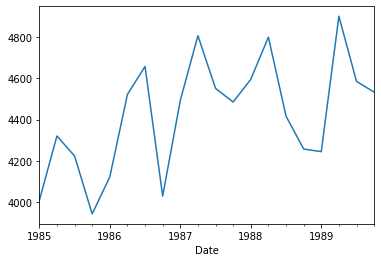

In [53]:
shipments_ts.plot()

In [54]:
shipments_ts

Date
1985-01-01    4009
1985-04-01    4321
1985-07-01    4224
1985-10-01    3944
1986-01-01    4123
1986-04-01    4522
1986-07-01    4657
1986-10-01    4030
1987-01-01    4493
1987-04-01    4806
1987-07-01    4551
1987-10-01    4485
1988-01-01    4595
1988-04-01    4799
1988-07-01    4417
1988-10-01    4258
1989-01-01    4245
1989-04-01    4900
1989-07-01    4585
1989-10-01    4533
Name: shipments, dtype: int64

In [55]:
# centered moving average with window size = 4
ma_centered = shipments_ts.rolling(4, center=True).mean()

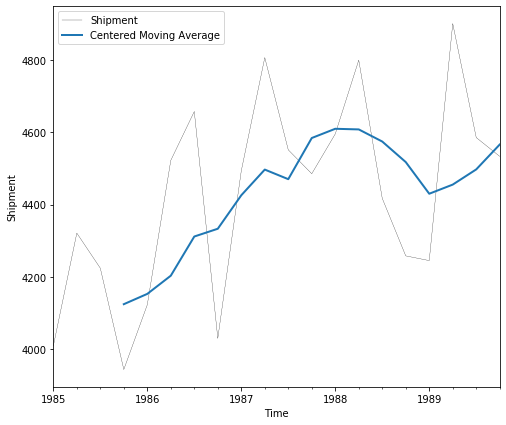

In [56]:
# shift the average by one time unit
ma_centered = pd.Series(ma_centered[:-1].values, index=ma_centered.index[1:])
fig, ax = plt.subplots(figsize=(8, 7))
ax = shipments_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_centered.plot(ax=ax, linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Shipment')
ax.legend(['Shipment', 'Centered Moving Average'])
plt.show()

What does the MA(4) chart reveal?

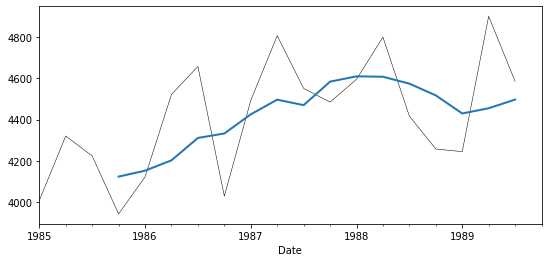

In [57]:
# partition the data
nValid = 1
nTrain = len(shipments_ts) - nValid

train_ts = shipments_ts[:nTrain]
valid_ts = shipments_ts[nTrain:]

# moving average on training
ma_trailing = train_ts.rolling(4).mean()
last_ma = ma_trailing[-1]

# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=valid_ts.index)

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
valid_ts.plot(ax=ax, color='black', linewidth=0.25)
ma_trailing.plot(ax=ax, linewidth=2, color='C0')
ma_trailing_pred.plot(ax=ax, style='--', linewidth=2, color='C0')

plt.show()

In [58]:
print(ma_trailing_pred)

Date
1989-10-01    4497.0
dtype: float64


Sales in Q1-1990 will be 4497.0 while sales in Q1-1991 will be (4497.0 + 4497.0 + 4497.0 + 4497.0)/4 = 4497.0

The forecast for Q1-1990 will underestimate the actual sales on Q1-1990. Looking at the series, there has been a steady rise in shipments up until 1989-01-01 and this shows that the moving average will most likely lag behind.

The analyst needs to know that MA(4) can't be used to forecast series with trend and seasonality. It's best applied to a deseasonalized series.

In [59]:
# Build a model with linear trend and seasonality
shipments_df = tsatools.add_trend(shipments_ts, trend='ct')
shipments_df['Quarter'] = shipments_df.index.quarter

# partition the data
nValid = 4
nTrain = len(shipments_ts) - nValid

train_df = shipments_df[:nTrain]
valid_df = shipments_df[nTrain:]

formula = 'shipments ~ trend + C(Quarter)'
shipments_lm_trendseason = sm.ols(formula=formula, data=train_df).fit()

# create single-point forecast
shipments_prediction = shipments_lm_trendseason.predict(valid_df.iloc[0:2])

In [60]:
print(shipments_prediction)

Date
1989-01-01    4662.25
1989-04-01    4969.25
dtype: float64


In [61]:
#Compute the MAPE for the validation data using the regression model

C:\Users\GETHSEMAN\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\GETHSEMAN\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\GETHSEMAN\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


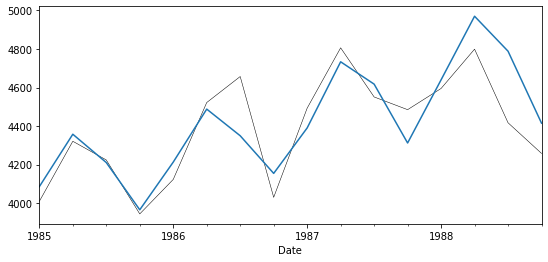

In [62]:
# partition the data
nValid = 4
nTrain = len(shipments_ts) - nValid

train_ts = shipments_ts[:nTrain]
valid_ts = shipments_ts[nTrain:]

# run exponential smoothing with additive trend and multiplicative seasonality
expSmooth = ExponentialSmoothing(train_ts, trend='additive', seasonal='multiplicative', seasonal_periods=4, freq=None)
expSmoothFit = expSmooth.fit(smoothing_level = 0.2, smoothing_slope=0.15, smoothing_seasonal = 0.05)

fig, ax = plt.subplots(figsize=(9,4))
train_ts.plot(ax=ax, color='black', linewidth=0.5)
#valid_ts.plot(ax=ax, color='black', linewidth=0.25)

expSmoothFit.fittedvalues.plot(ax=ax)
#expSmoothFit.forecast(len(valid_ts)).plot(ax=ax, style='--', linewidth=2, color='C0')


plt.show()

In [63]:
print(expSmoothFit.forecast(2))

1989-01-01    4645.303304
1989-04-01    4956.977148
Freq: QS-OCT, dtype: float64


In [64]:
#Compute the MAPE for the validation data using Holt-Winter's exponential smoothing

Is it possible to get MAPE value close to zero if we optimize smoothing parameters in the Holt-Winter's method?